In [2]:
import json
import os

import MeCab
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
t = MeCab.Tagger('-Owakati')


def tokenize(text):
    words = t.parse(text).rstrip().split()

    return words


def load_jsonl(jsonl_file):
    with open(jsonl_file) as f:
        for line in f:
            j = json.loads(line)
            yield j


def remove_tags(html):
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text()

    return text


def load_dataset(jsonl_file):
    X, y = [], []
    for j in load_jsonl(jsonl_file):
        text = remove_tags(j['text'])
        X.append(text)
        y.append(j['label'])

    return X, y


filename = './data/interim/dataset.jsonl'
test_size = 0.3

# Load datasets.
X, y = load_dataset(jsonl_file=filename)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

## ベースラインモデルの作成
まずはベースラインモデルを作成する。ここでは、各文書をBoWで表し、TF-IDF値に変換する。これをモデルへの入力とする。

In [3]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, analyzer='word')
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

分類のモデルにはロジスティック回帰を用いる。ここで、正則化にはL1正則化を用いる。ストップワードの除去を期待できるからである。

In [13]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
# clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

LinearSVC(C=0.3, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

学習が完了したら、テストデータに対して予測を行う。

In [14]:
y_pred = clf.predict(X_test)

最後に、予測したデータと正解データを用いて評価を行う。評価にはF1を用いる。

In [15]:
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='macro'))

0.950418077


0.895926915518


/Users/hironsan/PycharmProjects/entitypedia/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


classification_reportを用いて、各カテゴリごとの評価を表示する。

In [7]:
print(classification_report(y_test, y_pred, digits=3))

                                                                  precision    recall  f1-score   support

                                               color/color_other      0.917     0.917     0.917        48
                                              color/nature_color      0.667     0.667     0.667         3
                                          disease/animal_disease      0.941     0.899     0.920        89
                                           disease/disease_other      1.000     0.800     0.889        10
                                               event/event_other      0.980     0.988     0.984       246
                                   event/incident/incident_other      0.964     0.982     0.973       166
                                              event/incident/war      0.983     0.992     0.987       633
                             event/natural_phenomenon/earthquake      0.948     1.000     0.973        55
                       event/natural_phenomen

/Users/hironsan/PycharmProjects/entitypedia/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/hironsan/PycharmProjects/entitypedia/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


学習曲線を描くための関数を定義する

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return plt

実際に学習曲線を描いてみる。

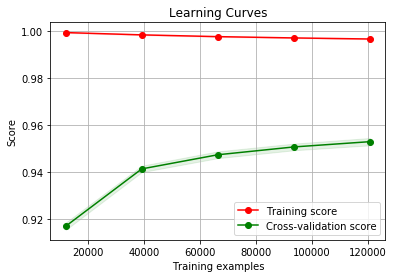

In [9]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LinearSVC()
plot_learning_curve(estimator, title, X_train, y_train, cv=cv)

plt.show()

学習スコアと検証スコアに若干(1%くらい?)の差がある。